# ML based prediction of condensation promoting or decreasing mutation

In [1]:
using Pkg; Pkg.activate("project")
using FASTX
using CSV
using PyPlot
using DataFrames
using ScikitLearn
using Random
using Seaborn
using Statistics
using LinearAlgebra

  Activating project at `~/Documents/Materiale UNI/V anno/Biological Datasets/code/project`


## Loading data and creating a uniform input dataset

In P22626,O43781, the given mutations refer to the second isoform, not the main one.
For P10636 both isoform 5 and 8 are compatible, i take 5.
In P31483 there seems to be an error in the mutation cell, i remove 3185 and the second appearing id.
I completely ignore P04150 as none of the wt residues match with any isoform.
P29350 to isoform 3.
Ignore Q9UM73, mentioned mutation position is even longer than the sequence, could not get the explanation in the paper.
Removed E1394K from Q13402, does not appear to exist.
Substituted Q9UPQ9 with the partner Q9UKV8, the mutations are referred to that.
Ignored Q96PV0, removed L539K in Q9Y5K6, not present nowhere.
P42858 ignored. 
Removed S48E,E17R,Y4R,W334G,W385G,W412G from Q13283

In [2]:
full_record = Dict()

# READING WILD TYPE .fasta
listdir = readdir("../data/WT")

w_seq = []
w_id = []
for f in listdir
    FASTAReader(open("../data/WT/$f")) do reader
       for record in reader
            push!(w_seq, sequence(record))
            push!(w_id, description(record))
       end
    end
end

# READING CONDENSATION PROMOTING MUTATIONS AND MATCHING WITH CORRESPONDING SEQUENCE
df = CSV.read("../data/promote.txt",DataFrame,header=0,silencewarnings=true)

data = []
for r in eachrow(df)
    i = 2
    id = r[1]
    full_record[id] = []
    mut = r[i]
    while typeof(mut) != Missing
        temp = []
        push!(temp, w_seq[w_id .== id][1])
        length(mut) < 3 && error("mutation wrong ", mut)
        mu_position = parse(Int,mut[2:end-1])
        mu_seq = temp[1]
        if mu_seq[mu_position] == mut[1]
            if mut[end] != 'X'
                first = mu_seq[1:mu_position-1]
                last = mu_seq[mu_position+1:end]
                mu_seq = "$first$(mut[end])$last"
            else
                mu_seq = mu_seq[1:mu_position-1]
            end
        else
            println(mu_seq[mu_position]," ",mut[1]," ",id," ",mu_position)
            error("mutated sequence and mutation annotations do not match")
        end
        push!(full_record[id], mut)
        push!(temp, mu_seq)
        push!(temp, 1) # condensate
        push!(data, temp)
        i = i < length(r) ? i + 1 : break
        mut = r[i]
    end
end

# READING CONDENSATION REDUCING MUTATIONS AND MATCHING WITH CORRESPONDING SEQUENCE
df = CSV.read("../data/reduce.txt",DataFrame,header=0,silencewarnings=true)
for r in eachrow(df)
    i = 2
    id = r[1]
    full_record[id] = []
    mut = r[i]
    while typeof(mut) != Missing
        temp = []
        push!(temp, w_seq[w_id .== id][1])
        length(mut) < 3 && error("mutation wrong ", mut)
        mu_position = parse(Int,mut[2:end-1])
        mu_seq = temp[1]
        if mu_seq[mu_position] == mut[1]
            if mut[end] != 'X'
                first = mu_seq[1:mu_position-1]
                last = mu_seq[mu_position+1:end]
                mu_seq = "$first$(mut[end])$last"
            else
                mu_seq = mu_seq[1:mu_position-1]
            end
        else
            println(mu_seq[mu_position]," ",mut[1]," ",id," ",mu_position)
            error("mutated sequence and mutation annotations do not match")
        end
        push!(full_record[id], mut)
        push!(temp, mu_seq)
        push!(temp, -1) # disolve
        push!(data, temp)
        i = i < length(r) ? i + 1 : break
        mut = r[i]
    end
end

listdir = readdir("../data/COND")

_seq = []
_id = []
for f in listdir
    FASTAReader(open("../data/COND/$f")) do reader
       for record in reader
            push!(_seq, sequence(record))
            push!(_id, description(record))
       end
    end
end

for (i,j) in zip(_seq,_id)
    temp = []
    mut = j[findfirst('_',j)+1:end]
    id = j[1:findfirst('_',j)-1]
    if findfirst(x -> x == id, w_id) != nothing
        continue
    end
    full_record[id] = []
    mu_position = parse(Int,mut[2:end-1])
    wt = i
    if wt[mu_position] == mut[end]
        if mut[end] != 'X'
            first = wt[1:mu_position-1]
            last = wt[mu_position+1:end]
            wt = "$first$(mut[1])$last"
        else
            wt = ""
            print("wt not reconstructed")
        end
    else
        println(mu_seq[mu_position]," ",mut[1]," ",id," ",mu_position)
        error("mutated sequence and mutation annotations do not match")
    end
    push!(full_record[id], mut)
    push!(temp, wt)
    length(mut) < 3 && error("mutation wrong ", mut)
    push!(temp, mut)
    push!(temp, 1)
    push!(data, temp)
end

listdir = readdir("../data/DISOLV")

_seq = []
_id = []
for f in listdir
    FASTAReader(open("../data/DISOLV/$f")) do reader
       for record in reader
            push!(_seq, sequence(record))
            push!(_id, description(record))
       end
    end
end

for (i,j) in zip(_seq,_id)
    temp = []
    mut = j[findfirst('_',j)+1:end]
    id = j[1:findfirst('_',j)-1]
    if findfirst(x -> x == id, w_id) != nothing
        continue
    end
    full_record[id] = []
    mu_position = parse(Int,mut[2:end-1])
    wt = i
    if wt[mu_position] == mut[end]
        if mut[end] != 'X'
            first = wt[1:mu_position-1]
            last = wt[mu_position+1:end]
            wt = "$first$(mut[1])$last"
        else
            wt = ""
            print("wt not reconstructed")
        end
    else
        println(mu_seq[mu_position]," ",mut[1]," ",id," ",mu_position)
        error("mutated sequence and mutation annotations do not match")
    end
    push!(full_record[id], mut)
    push!(temp, wt)
    length(mut) < 3 && error("mutation wrong ", mut)
    push!(temp, mut)
    push!(temp, -1)
    push!(data, temp)
end
    

Printing latex table

In [3]:
open("complete_dataset.txt", "w") do f
    for p in keys(full_record)
        typeof(p) == Missing && continue 
        print(f, p)
        for m in full_record[p]
            print(f, " & ", m)
        end
        print(f, " \\\\ \n")
    end
end

In [4]:
maximum(length.(values(full_record))) + 1

17

## Preprocessing of data

### Computing $\Delta S$

In [4]:
amino = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'];

In [5]:
DS = map(data) do d
    p_i = zeros(length(amino))
    p_i = map(p_i,amino) do p,a
        for i in d[1]
            if a == i 
                p += 1 
            end
        end
        p = p / length(d[1])
    end
    p_i = p_i[p_i .> 0]
    S_wt = - sum(p*log(p) for p in p_i)
    p_i = zeros(length(amino))
    p_i = map(p_i,amino) do p,a
        for i in d[2]
            if a == i 
                p += 1 
            end
        end
        p = p / length(d[2])
    end
    p_i = p_i[p_i .> 0]
    S_mu = - sum(p*log(p) for p in p_i)
    S_mu - S_wt
end;

### KL divergence

In [6]:
KL = map(data) do d
    p_i = zeros(length(amino))
    p_i = map(p_i,amino) do p,a
        for i in d[1]
            if a == i 
                p += 1 
            end
        end
        p = p / length(d[1])
    end
    q_i = zeros(length(amino))
    q_i = map(q_i,amino) do p,a
        for i in d[2]
            if a == i 
                p += 1 
            end
        end
        p = p / length(d[2])
    end
    KL_i = map(p_i,q_i) do p,q
        if p == 0
            0
        elseif q == 0
            1e20
        else
            p*log(p/q)
        end
    end
    sum(KL_i)
end;

### Hydrophobicity change

In [7]:
#amino = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
charge = ["NP", "NP", "-", "-", "NP", "NP", "+", "NP", "+", "NP", "NP", "P", "NP", "P", "+", "P", "P", "NP", "NP", "P"];
charge_dict = Dict(zip(amino,charge));

In [8]:
HP = map(data) do d
    temp = 0
    for (w,m) in zip(d[1],d[2])
        if w == m
            continue
        elseif (charge_dict[w] == "NP") && (charge_dict[m] == "P" || charge_dict[m] == "+" || charge_dict[m] == "-")
            temp += 1
        elseif (charge_dict[m] == "NP") && (charge_dict[w] == "P" || charge_dict[w] == "+" || charge_dict[w] == "-")
            temp += 1
        end
    end
    if length(d[1]) > length(d[2])
        temp =  temp + length(d[1]) - length(d[2])
    end
    temp/length(d[2])
end;

#### Kyte-Doolittle

In [9]:
#amino = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
hyd_scale = [1.8,2.5,-3.5,-3.5,2.8,-0.4,-3.2,4.5,-3.9,3.8,1.9,-3.5,-1.6,-3.5,-4.5,-0.8,-0.7,4.2,-0.9,-1.3];
hyd_dict = Dict(zip(amino,hyd_scale));

In [73]:
KD = map(data) do d
    temp = 0
    for (w,m) in zip(d[1],d[2])
        if w == m
            continue
        else
            temp += hyd_dict[m] - hyd_dict[w]
        end
    end
    if length(d[1]) > length(d[2])
        temp -= sum([hyd_dict[w] for w in d[1][length(d[2])+1:length(d[1])]])
    end
    # temp/length(d[2])
    temp
end;

### Charge change

In [10]:
CC = map(data) do d
    temp = 0
    for (w,m) in zip(d[1],d[2])
        if w == m 
            continue
        elseif (charge_dict[w] == "NP" || charge_dict[w] == "P") && (charge_dict[m] == "+")
            temp += 1
        elseif (charge_dict[w] == "NP" || charge_dict[w] == "P") && (charge_dict[m] == "-")
            temp -= 1
        elseif (charge_dict[m] == "NP" || charge_dict[m] == "P") && (charge_dict[w] == "+")
            temp -= 1
        elseif (charge_dict[m] == "NP" || charge_dict[m] == "P") && (charge_dict[w] == "-")
            temp += 1
        elseif charge_dict[w] == "+" && charge_dict[m] == "-"
            temp = temp - 2
        elseif charge_dict[m] == "+" && charge_dict[w] == "-"
            temp = temp + 2
        end
    end
    if length(d[1]) > length(d[2])
        for w in d[1][length(d[2])+1:end]
            if charge_dict[w] == "+"
                temp -= 1
            elseif charge_dict[w] == "-"
                temp += 1
            end
        end
    end
    temp/length(d[2])
end;

## Training the model

In [11]:
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 15
rcParams["font.serif"] = "Palatino"
rcParams["font.sans-serif"] = "Trebuchet MS"
rcParams["font.weight"] = "bold"
rcParams["axes.titleweight"] = "bold"
rcParams["axes.labelweight"] = "bold"

"bold"

In [12]:
@sk_import ensemble: GradientBoostingClassifier
@sk_import model_selection: GridSearchCV
;

[ Info: mkl not found, proceeding to installing non-mkl versions of sci-kit learn via Conda
[ Info: Running `conda install -y -c conda-forge 'scikit-learn>=1.2,<1.3'` in root environment


Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 24.4.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.4.0


┌ Warning: Module model_selection has been ported to Julia - try `import ScikitLearn: CrossValidation` instead
└ @ ScikitLearn.Skcore ~/.julia/packages/ScikitLearn/sqLdT/src/Skcore.jl:259


In [137]:
Y = [i[3] for i in data]
X = Matrix(undef,length(Y),4)
X[:,1] = DS
X[:,2] = KL
# X[:,3] = HP
X[:,4] = CC
X[:,3] = KD

Random.seed!(1234)
perm = randperm(length(Y))
Y = Y[perm]
X = X[perm,:]

train = Int(trunc(length(Y) * 0.8))
X_train = X[1:train,:]
Y_train = Y[1:train]
X_test = X[train+1:end,:]
Y_test = Y[train+1:end];

In [16]:
length(Y)

206

### correlation between features

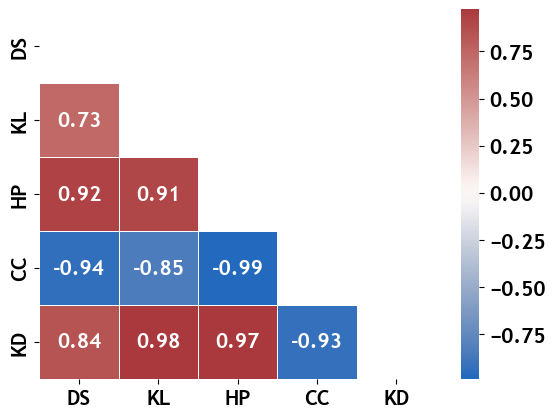

In [104]:
cor_mat = cor(X)
features = ["DS","KL","HP","CC","KD"]
mask = triu(ones(5,5))
heatmap(cor_mat,mask=mask,cmap="vlag",annot=true,linewidths=0.5,center=0,xticklabels=features,yticklabels=features);
# savefig("correlation.pdf")

### z-scores

In [75]:
DS_c = DS[Y .== 1]
DS_d = DS[Y .== -1]
KL_c = KL[Y .== 1]
KL_d = KL[Y .== -1]
HP_c = HP[Y .== 1]
HP_d = HP[Y .== -1]
CC_c = CC[Y .== 1]
CC_d = CC[Y .== -1]

println("DS: ", (mean(DS_c)-mean(DS_d))/sqrt(std(DS_c)^2+std(DS_d)^2))
println("KL: ", (mean(KL_c)-mean(KL_d))/sqrt(std(KL_c)^2+std(KL_d)^2))
println("HP: ", (mean(HP_c)-mean(HP_d))/sqrt(std(HP_c)^2+std(HP_d)^2))
println("CC: ", (mean(CC_c)-mean(CC_d))/sqrt(std(CC_c)^2+std(CC_d)^2))

DS: 0.09825950445499153
KL: 0.018832492412845347
HP: 0.07730193456282218
CC: -0.08356838401559795


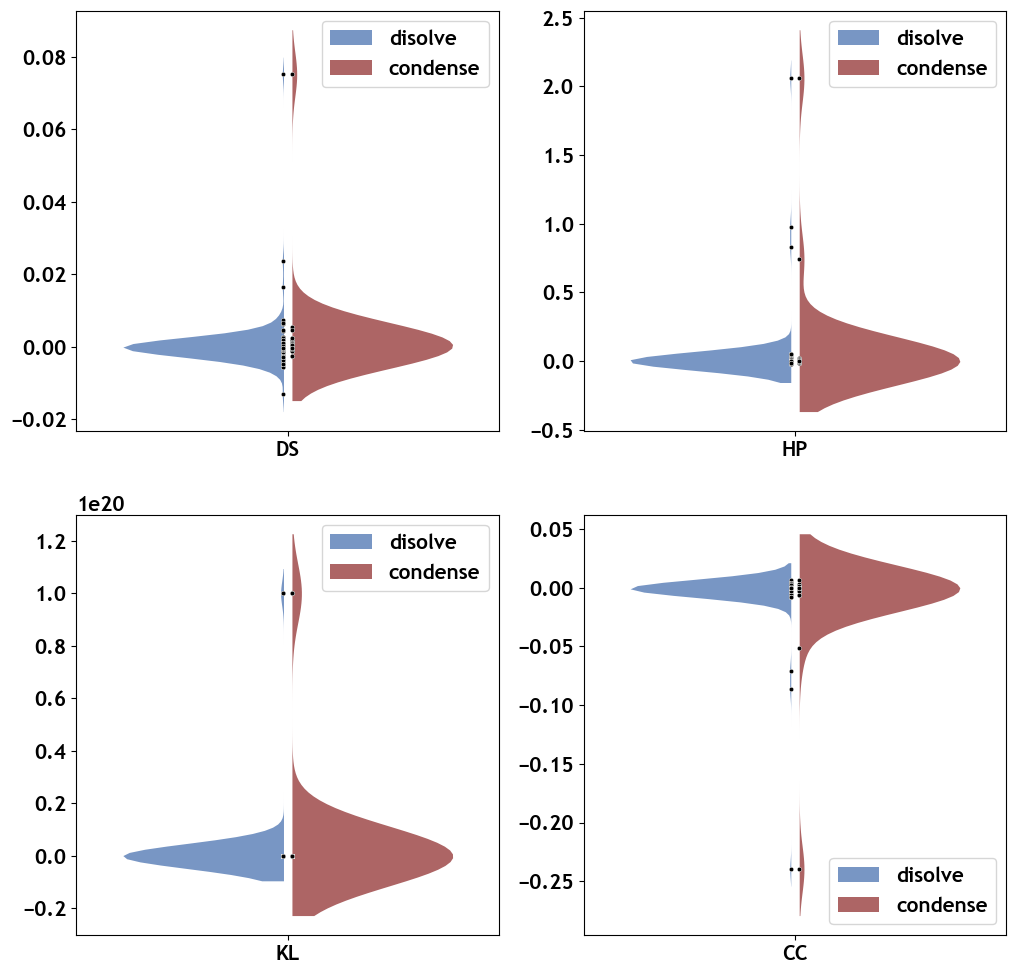

PyObject <matplotlib.legend.Legend object at 0x1a714b100>

In [19]:
f, ax = subplots(2,2,figsize=(12,12))
pal = Dict("condense"=>(154/256,62/256,62/256,0.8),"disolve"=>(86/256,124/256,183/256,0.8))
violinplot(x=["DS" for i in 1:length(Y)],y=DS,hue=[i==1 ? "condense" : "disolve" for i in Y],split=true,ax=ax[1],gap=0.05,inner="point",inner_kws=Dict("color"=>"black","s"=>10,"linewidths"=>0.3,"edgecolor"=>"white"),palette=pal,saturation=1,linewidth=0)
violinplot(x=["KL" for i in 1:length(Y)],y=KL,hue=[i==1 ? "condense" : "disolve" for i in Y],split=true,ax=ax[2],gap=0.05,inner="point",inner_kws=Dict("color"=>"black","s"=>10,"linewidths"=>0.3,"edgecolor"=>"white"),palette=pal,saturation=1,linewidth=0)
violinplot(x=["HP" for i in 1:length(Y)],y=HP,hue=[i==1 ? "condense" : "disolve" for i in Y],split=true,ax=ax[3],gap=0.05,inner="point",inner_kws=Dict("color"=>"black","s"=>10,"linewidths"=>0.3,"edgecolor"=>"white"),palette=pal,saturation=1,linewidth=0)
violinplot(x=["CC" for i in 1:length(Y)],y=CC,hue=[i==1 ? "condense" : "disolve" for i in Y],split=true,ax=ax[4],gap=0.05,inner="point",inner_kws=Dict("color"=>"black","s"=>10,"linewidths"=>0.3,"edgecolor"=>"white"),palette=pal,saturation=1,linewidth=0)
ax[4].legend(loc="lower right")
# savefig("violins.pdf",bbox_inches="tight")

In [20]:
length(Y[Y .== 1])/length(Y), length(Y[Y .== -1])/length(Y)

(0.17475728155339806, 0.8252427184466019)

In [79]:
BDT = GradientBoostingClassifier(random_state=4)
params = Dict("n_estimators" => [100,1000,10000], 
              "learning_rate" => [#=1.,0.1,0.05,=#0.01],
              "max_depth" => [1,2,3,5,10,15])

Dict{String, Vector} with 3 entries:
  "max_depth"     => [1, 2, 3, 5, 10, 15]
  "learning_rate" => [0.01]
  "n_estimators"  => [100, 1000, 10000]

In [131]:
models = GridSearchCV(BDT, param_grid=params, cv=10).fit(X,Y)

PyObject GridSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=4),
             param_grid={'learning_rate': array([0.01]),
                         'max_depth': array([ 1,  2,  3,  5, 10, 15], dtype=int64),
                         'n_estimators': array([  100,  1000, 10000], dtype=int64)})

In [87]:
models.best_score_, models.best_params_

(0.8257142857142856, Dict{Any, Any}("max_depth" => 1, "learning_rate" => 0.01, "n_estimators" => 100))

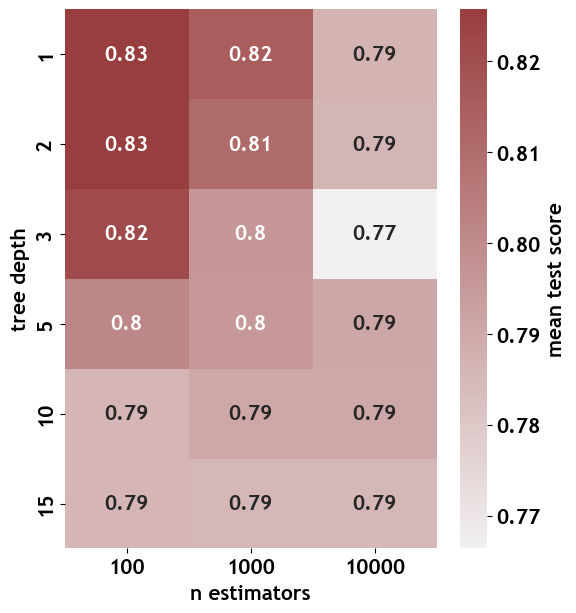

PyObject Text(29.625000000000007, 0.5, 'tree depth')

In [132]:
fig = figure(figsize=(6,7))
grid_mat = Matrix(undef,length(params["max_depth"]),length(params["n_estimators"]))

for (p,s) in zip(models.cv_results_["params"],models.cv_results_["mean_test_score"])
    if p["learning_rate"] == 0.01
        row = searchsortedfirst(params["max_depth"],p["max_depth"])
        column = searchsortedfirst(params["n_estimators"],p["n_estimators"])
        grid_mat[row,column] = s
    end
end

cmap = light_palette(color=(154/256,62/256,62/256), input="rgb", as_cmap=true)
heatmap(grid_mat,annot=true,cmap=cmap,xticklabels=params["n_estimators"],yticklabels=params["max_depth"],cbar_kws=Dict("label"=>"mean test score"))
xlabel("n estimators")
ylabel("tree depth")
# savefig("grid.pdf",bbox_inches="tight")

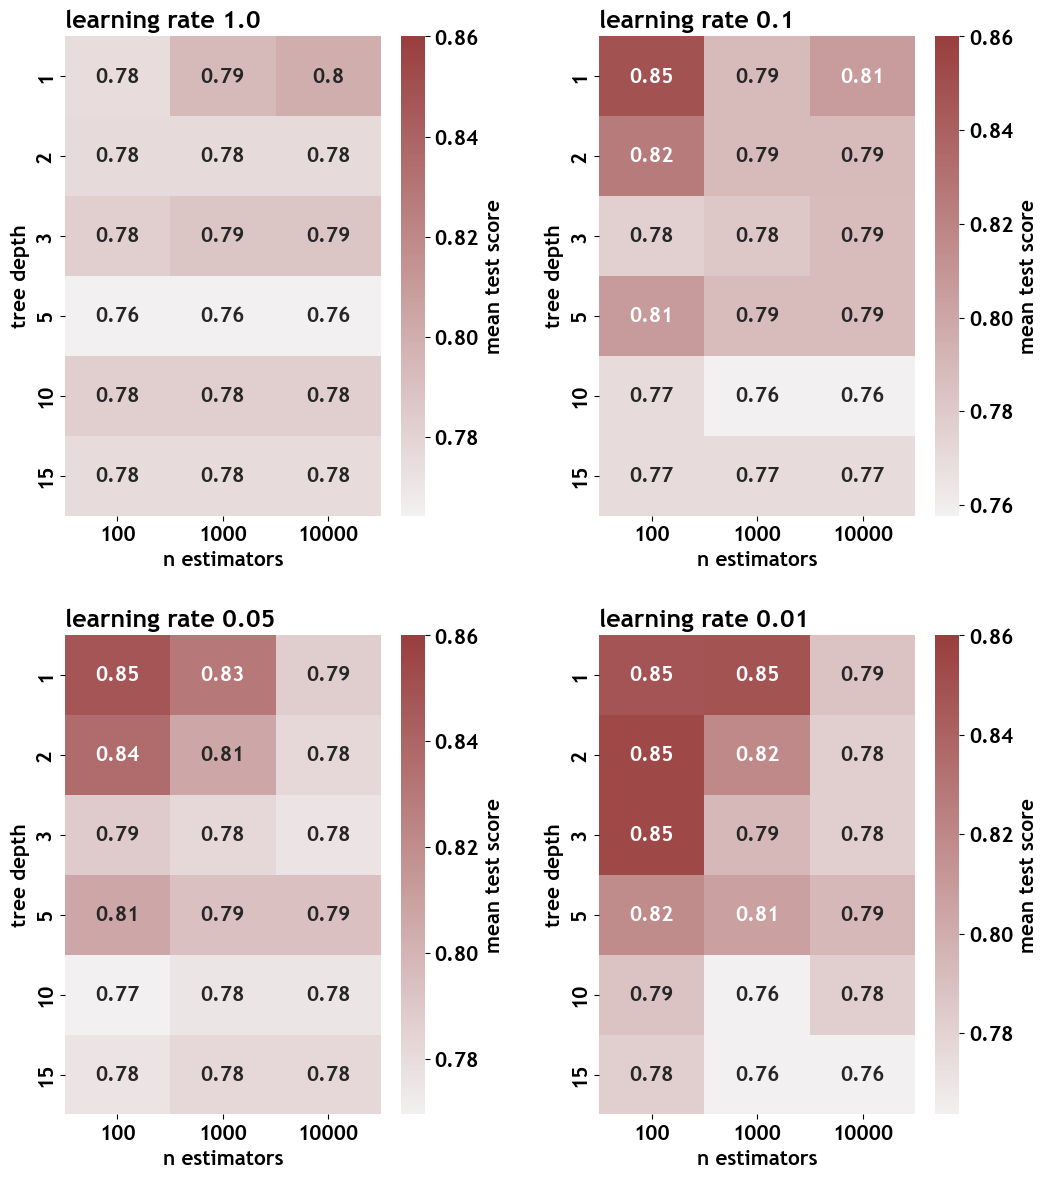

In [23]:
fig = figure(figsize=(12,14))
panels = ["learning rate 1.0", "learning rate 0.1", "learning rate 0.05", "learning rate 0.01"]
ax = fig.subplot_mosaic([["learning rate 1.0", "learning rate 0.1"],["learning rate 0.05", "learning rate 0.01"]],gridspec_kw=Dict("wspace"=>0.35,"hspace"=>0.25))
ax[panels[1]].set_title(panels[1],loc="left")
ax[panels[2]].set_title(panels[2],loc="left")
ax[panels[3]].set_title(panels[3],loc="left")
ax[panels[4]].set_title(panels[4],loc="left")

grid_mat = Matrix(undef,length(params["max_depth"]),length(params["n_estimators"]))

iter = 0
for l in params["learning_rate"]
    for (p,s) in zip(models.cv_results_["params"],models.cv_results_["mean_test_score"])
        if p["learning_rate"] == l
            row = searchsortedfirst(params["max_depth"],p["max_depth"])
            column = searchsortedfirst(params["n_estimators"],p["n_estimators"])
            grid_mat[row,column] = s
        end
    end
    iter += 1
    cmap = light_palette(color=(154/256,62/256,62/256), input="rgb", as_cmap=true)
    heatmap(grid_mat,annot=true,cmap=cmap,vmax=0.86,xticklabels=params["n_estimators"],yticklabels=params["max_depth"],cbar_kws=Dict("label"=>"mean test score"),ax=ax[panels[iter]])
    ax[panels[iter]].set_xlabel("n estimators")
    ax[panels[iter]].set_ylabel("tree depth")
end
# savefig("grid_full.pdf",bbox_inches="tight")

In [24]:
models.score(X_test,Y_test)

0.7857142857142857

In [25]:
Random.seed!(12345)
perm = randperm(length(X[1,:]))
perm = perm[1] == 1 ? 5 .- perm : perm
X_train = X_train[:,perm];
X_test = X_test[:,perm];

In [26]:
perm

4-element Vector{Int64}:
 4
 1
 3
 2

In [138]:
BDT2 = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.01, max_depth = 10, random_state=4).fit(X_train,Y_train)
BDT2.score(X_test,Y_test)

0.8095238095238095

In [139]:
BDT2.train_score_[1]

0.8941900905528781

In [32]:
BDT2.score(X_train,Y_train)

1.0

mis-predicted data points

In [38]:
Y_pred = BDT2.predict(X[:,perm])
X[Y_pred .!= Y, :]

6×4 Matrix{Any}:
  0.000673593  0.00033805  0.0          0.00636943
  0.000351185  8.80903e-5  0.00214592   0.0
  0.00129686   9.08891e-5  0.0          0.0
  0.000301969  6.06521e-5  0.00168634   0.0
 -0.0131371    0.0013447   0.0          0.0
 -0.00165063   0.00181503  0.00315457  -0.00315457

accuracy

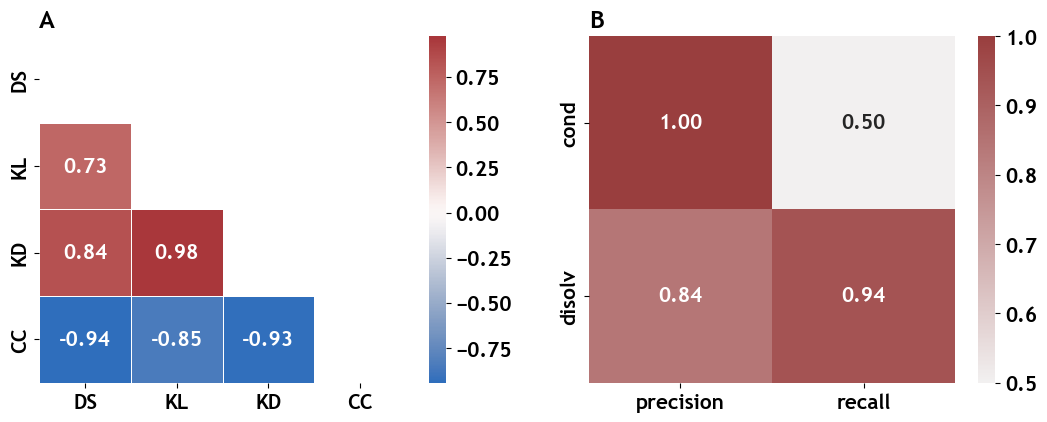

In [140]:
fig = figure(figsize=(13,4.5))
ax = fig.subplot_mosaic("AB")
ax["A"].set_title("A",loc="left")
ax["B"].set_title("B",loc="left")

# fig.text(size=15)

cor_mat = cor(X)
features = ["DS","KL","KD","CC"]
mask = triu(ones(4,4))
heatmap(cor_mat,mask=mask,cmap="vlag",annot=true,linewidths=0.5,center=0,xticklabels=features,yticklabels=features,ax=ax["A"]);

Y_pred = BDT2.predict(X_test)
p_c = length(Y_pred[Y_pred .== 1 .& Y_test .== 1])/length(Y_pred[Y_pred .== 1])
r_c = length(Y_pred[Y_pred .== 1 .& Y_test .== 1])/length(Y_pred[Y_test .== 1])
p_d = length(Y_pred[Y_pred .== -1 .& Y_test .== -1])/length(Y_pred[Y_pred .== -1])
r_d = length(Y_pred[Y_pred .== -1 .& Y_test .== -1])/length(Y_pred[Y_test .== -1])
acc_mat = [p_c r_c; p_d r_d]
ylabels = ["cond","disolv"]
xlabels = ["precision","recall"]
cmap = light_palette(color=(154/256,62/256,62/256), input="rgb", as_cmap=true)
heatmap(acc_mat,annot=true,cmap=cmap,fmt=".2f",xticklabels=xlabels,yticklabels=ylabels,ax=ax["B"]);

# savefig("heatmaps.pdf",bbox_inches="tight")

feature importance

In [141]:
BDT2.feature_importances_

4-element Vector{Float64}:
 0.11017668436121013
 0.3110232908648576
 0.2922903104075311
 0.28650971436640105

## deployment

In [153]:
BDT_dpl = GradientBoostingClassifier(n_estimators = 1000, learning_rate = 0.01, max_depth = 1, random_state=4, 
    validation_fraction=0.2, n_iter_no_change=20).fit(X,Y)

PyObject GradientBoostingClassifier(learning_rate=0.01, max_depth=1, n_estimators=1000,
                           n_iter_no_change=20, random_state=4,
                           validation_fraction=0.2)

In [154]:
BDT_dpl.train_score_[1]

0.9309250381040054

In [155]:
BDT_dpl.score(X,Y)

0.8398058252427184

accuracy

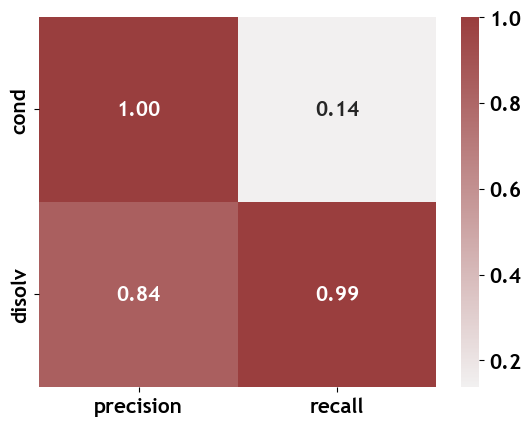

In [156]:
# fig = figure(figsize=(12,10))
Y_pred = BDT_dpl.predict(X)
p_c = length(Y_pred[Y_pred .== 1 .& Y .== 1])/length(Y_pred[Y_pred .== 1])
r_c = length(Y_pred[Y_pred .== 1 .& Y .== 1])/length(Y_pred[Y .== 1])
p_d = length(Y_pred[Y_pred .== -1 .& Y .== -1])/length(Y_pred[Y_pred .== -1])
r_d = length(Y_pred[Y_pred .== -1 .& Y .== -1])/length(Y_pred[Y .== -1])
acc_mat = [p_c r_c; p_d r_d]
ylabels = ["cond","disolv"]
xlabels = ["precision","recall"]
cmap = light_palette(color=(154/256,62/256,62/256), input="rgb", as_cmap=true)
heatmap(acc_mat,annot=true,cmap=cmap,fmt=".2f",xticklabels=xlabels,yticklabels=ylabels,vmax=1.0);
# savefig("prec_depl.pdf",bbox_inches="tight")

feature importance

In [146]:
BDT_dpl.feature_importances_

4-element Vector{Float64}:
 0.28360198852247265
 0.019729888750348264
 0.5557175183820039
 0.1409506043451751